<a href="https://colab.research.google.com/github/ayulockin/SwAV-TF/blob/master/Train_SwAV_10_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setups

In [1]:
# Clone this repository to use the utils
!git clone https://github.com/ayulockin/SwAV-TF.git

Cloning into 'SwAV-TF'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 279 (delta 46), reused 13 (delta 7), pack-reused 198
Receiving objects: 100% (279/279), 18.72 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [2]:
import sys
sys.path.append('SwAV-TF/utils')

import multicrop_dataset
import architecture

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import random
import time
import os

from itertools import groupby
from tqdm import tqdm

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb

wandb.login()

# Flower Dataset

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"]
)

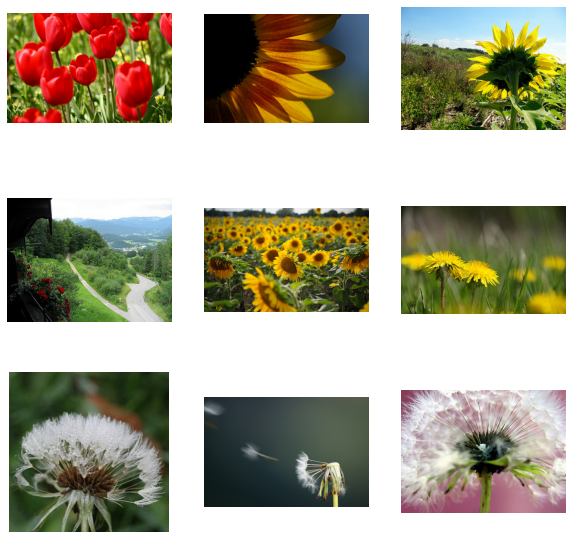

In [5]:
# Visualization
plt.figure(figsize=(10, 10))
for i, image  in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image['image'])
    plt.axis("off")

# Multi Crop Resize Data Augmentation

In [6]:
# Configs
BS = 32
SIZE_CROPS = [224, 96]
NUM_CROPS = [2, 3]
MIN_SCALE = [0.5, 0.14] 
MAX_SCALE = [1., 0.5]

# Experimental options
options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
options.experimental_optimization.apply_default_optimizations = True
options.experimental_deterministic = False
options.experimental_threading.max_intra_op_parallelism = 1

In [ ]:
# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(train_ds,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

In [8]:
# Prepare the final data loader

AUTO = tf.data.experimental.AUTOTUNE

# Zipping 
trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

# Final trainloader
trainloaders_zipped = (
    trainloaders_zipped
    .batch(BS)
    .prefetch(AUTO)
)

im1, im2, im3, im4, im5 = next(iter(trainloaders_zipped))
print(im1.shape, im2.shape, im3.shape, im4.shape, im5.shape)

(32, 224, 224, 3) (32, 224, 224, 3) (32, 96, 96, 3) (32, 96, 96, 3) (32, 96, 96, 3)


# Model Architecture

In [9]:
feature_backbone = architecture.get_resnet_backbone()
feature_backbone.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
projection_prototype = architecture.get_projection_prototype(2048, 128, 15)
projection_prototype.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         4196352     input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048)         8192        dense[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 2048)         0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Sinkhorn Knopp for Cluster Assignment
Reference: A.1 from https://arxiv.org/abs/2006.09882

In [11]:
def sinkhorn(sample_prototype_batch):
    Q = tf.transpose(tf.exp(sample_prototype_batch/0.05))
    Q /= tf.keras.backend.sum(Q)
    K, B = Q.shape

    u = tf.zeros_like(K, dtype=tf.float32)
    r = tf.ones_like(K, dtype=tf.float32) / K
    c = tf.ones_like(B, dtype=tf.float32) / B

    for _ in range(3):
        u = tf.keras.backend.sum(Q, axis=1)
        Q *= tf.expand_dims((r / u), axis=1)
        Q *= tf.expand_dims(c / tf.keras.backend.sum(Q, axis=0), 0)

    final_quantity = Q / tf.keras.backend.sum(Q, axis=0, keepdims=True)
    final_quantity = tf.transpose(final_quantity)

    return final_quantity

# Train Step

In [ ]:
# @tf.function
# Reference: https://github.com/facebookresearch/swav/blob/master/main_swav.py
def train_step(input_views, feature_backbone, projection_prototype, 
               optimizer, crops_for_assign, temperature):
    # ============ retrieve input data ... ============
    im1, im2, im3, im4, im5 = input_views 
    inputs = [im1, im2, im3, im4, im5]
    batch_size = inputs[0].shape[0]

    # ============ create crop entries with same shape ... ============
    crop_sizes = [inp.shape[1] for inp in inputs] # list of crop size of views
    unique_consecutive_count = [len([elem for elem in g]) for _, g in groupby(crop_sizes)] # equivalent to torch.unique_consecutive
    idx_crops = tf.cumsum(unique_consecutive_count)
    
    # ============ multi-res forward passes ... ============
    start_idx = 0
    with tf.GradientTape() as tape:
        for end_idx in idx_crops:
            concat_input = tf.stop_gradient(tf.concat(inputs[start_idx:end_idx], axis=0))
            _embedding = feature_backbone(concat_input) # get embedding of same dim views together
            if start_idx == 0:
                embeddings = _embedding # for first iter
            else:
                embeddings = tf.concat((embeddings, _embedding), axis=0) # concat all the embeddings from all the views
            start_idx = end_idx
        
        projection, prototype = projection_prototype(embeddings) # get normalized projection and prototype
        projection = tf.stop_gradient(projection)

        # ============ swav loss ... ============
        # https://github.com/facebookresearch/swav/issues/19
        loss = 0
        for i, crop_id in enumerate(crops_for_assign): # crops_for_assign = [0,1]
            with tape.stop_recording():
                out = prototype[batch_size * crop_id: batch_size * (crop_id + 1)]
                
                # get assignments
                q = sinkhorn(out) # sinkhorn is used for cluster assignment
            
            # cluster assignment prediction
            subloss = 0
            for v in np.delete(np.arange(np.sum(NUM_CROPS)), crop_id): # (for rest of the portions compute p and take cross entropy with q)
                p = tf.nn.softmax(prototype[batch_size * v: batch_size * (v + 1)] / temperature) 
                subloss -= tf.math.reduce_mean(tf.math.reduce_sum(q * tf.math.log(p), axis=1))
            loss += subloss / tf.cast((tf.reduce_sum(NUM_CROPS) - 1), tf.float32)
        
        loss /= len(crops_for_assign)

    # ============ backprop ... ============
    variables = feature_backbone.trainable_variables + projection_prototype.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

# Training Loop

In [ ]:
def train_swav(feature_backbone, 
               projection_prototype, 
               dataloader, 
               optimizer, 
               crops_for_assign,
               temperature, 
               epochs=50):
  
    step_wise_loss = []
    epoch_wise_loss = []
    
    for epoch in range(epochs):
        w = projection_prototype.get_layer('prototype').get_weights()
        w = tf.transpose(w)
        w = tf.math.l2_normalize(w, axis=1)
        projection_prototype.get_layer('prototype').set_weights(tf.transpose(w))

        for i, inputs in enumerate(dataloader):
            loss = train_step(inputs, feature_backbone, projection_prototype, 
                              optimizer, crops_for_assign, temperature)
            step_wise_loss.append(loss)
        epoch_wise_loss.append(np.mean(step_wise_loss))

        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))
        wandb.log({'epoch': epoch, 'loss':np.mean(step_wise_loss)})

    return epoch_wise_loss, [feature_backbone, projection_prototype]

In [ ]:
# ============ re-initialize the networks and the optimizer ... ============
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(15)

decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

# ================= initialize wandb ======================
wandb.init(entity='authors', project='swav-tf')

# ======================= train  ===========================
epoch_wise_loss, models = train_swav(feature_backbone, 
    projection_prototype, 
    trainloaders_zipped, 
    opt,
    crops_for_assign=[0, 1],
    temperature=0.1, 
    epochs=10
)

wandb: Wandb version 0.9.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch: 1 loss: 2.753
epoch: 2 loss: 2.731
epoch: 3 loss: 2.723
epoch: 4 loss: 2.720
epoch: 5 loss: 2.718
epoch: 6 loss: 2.716
epoch: 7 loss: 2.715
epoch: 8 loss: 2.714
epoch: 9 loss: 2.714
epoch: 10 loss: 2.713


In [ ]:
# Serialize the models
feature_backbone, projection_prototype = models
feature_backbone.save_weights('feature_backbone_10_epochs.h5')
projection_prototype.save_weights('projection_prototype_10_epochs.h5')